# Text Analysis from The Last of Us 2 Metacritic Users Reviews

This notebook seeks to extract and analyze text data from Metacritic Users Reviews, to try and understand the review bombing the game suffered with its release.

First, we will use `beatiful soup` to extract the reviews from the website. Then, we will use a number of text analysis libs to generate insights from the gathered data.

-------------------

## 1. Importing Libs

Below, we import the libs we will use over the analysis:

In [275]:
import pandas as pd ## As usual, to deal with our dataframes
import requests ## To access the website
from bs4 import BeautifulSoup ## To extract the html features from the page
import time as time ## To respectfuly gather data from the site and don't overwhelm them.
import random as rand 
from IPython.display import clear_output, Image
from nltk.util import ngrams ## Very useful to understand n-grams on text.
import re

from nltk.corpus import stopwords
import string

import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')

import seaborn as sns
from matplotlib import pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Extracting Data

First, we will create a dictionary that will store the gathered data into our desired bins. For this analysis, we will extract the date of the review, the rating of the review and the text.

In [192]:
review_dict = {'date':[], 'rating':[], 'review':[]}


In [193]:
user_agents_list = ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
                    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
                    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36']

Below, we gather the data from the website.

I gathered data from the first 367 pages, that were the total number of pages in the moment of analysis.

I've also set a sleep time of 1 second, so we don't affect too much the traffic in the website.

In [119]:
for page in range(0,367): #Remember to update the number of pages 
    url = 'https://www.metacritic.com/game/playstation-4/the-last-of-us-part-ii/user-reviews?sort-by=score&num_items=100&page='+str(page)
    user_agent = {'User-agent': user_agents_list[rand.randint(0,len(user_agents_list)-1)]}
    response  = requests.get(url, headers = user_agent)
    time.sleep(1) 
    soup = BeautifulSoup(response.text, 'html.parser')
    
    ## Here, we loop through all html div classes with the 'review content' tag. Those are the review blocks.
    for review in soup.find_all('div', class_='review_content'):
        
        ## Here, we check if the name or review are empty, if so, we skip this review.
        if review.find('div', class_='name') == None or review.find('div', class_='review_body').find('span') == None:
                break
        review_dict['date'].append(review.find('div', class_='date').text)
        review_dict['rating'].append(review.find('div', class_='review_grade').find_all('div')[0].text)
        ## Now, we check if the review is hidden due to its size. If so, we take the review from within this object.
        if review.find('span', class_='blurb blurb_expanded'):
            review_dict['review'].append(review.find('span', class_='blurb blurb_expanded').text)

        else:
            review_dict['review'].append(review.find('div', class_='review_body').find('span').text)
    
    ## This just prints the page we're in
    clear_output(wait = True)    
    print(page)
    
clear_output(wait = True)    

366


Now, we convert the dictionary filled with our data to a DataFrame.

In [123]:
reviews = pd.DataFrame(review_dict)

Below, we saved our dataframe to a csv, so we don't need to crawl the website everytime.

In [194]:
#reviews.to_csv('datasets/reviews.csv')
reviews = pd.read_csv('datasets/reviews.csv')

## 3. Review Analysis

First, let us do some non-textual analysis. Let's understand the distribution of the ratings over the days.

Also, let's keep in mind some key information:

1. The game was released on June 19th.
2. The average gameplay time is +/- 25 hours


### 3.1 Reviews per day

Let's first understand the distribution of reviews per day.

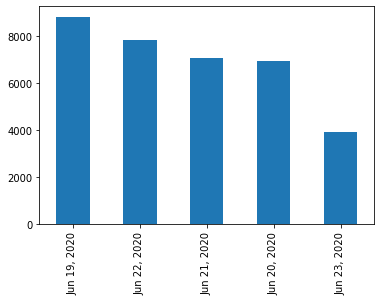

In [216]:
reviews['date'].value_counts().plot.bar();

We see that the majority of reviews were made on the release date. This is a good sign of review bombing, given that people would not have the time to play the game and offer a proper review. It may also suggest that the game is really bad and that you could say that after a few hours into it.

But let's dig deeper. Let's break that graph into good and bad reviews.

In [259]:
reviews['rating'] = reviews['rating'].astype(int)

reviews['good'] = False
reviews.loc[reviews['rating'] > 6,'good'] = True

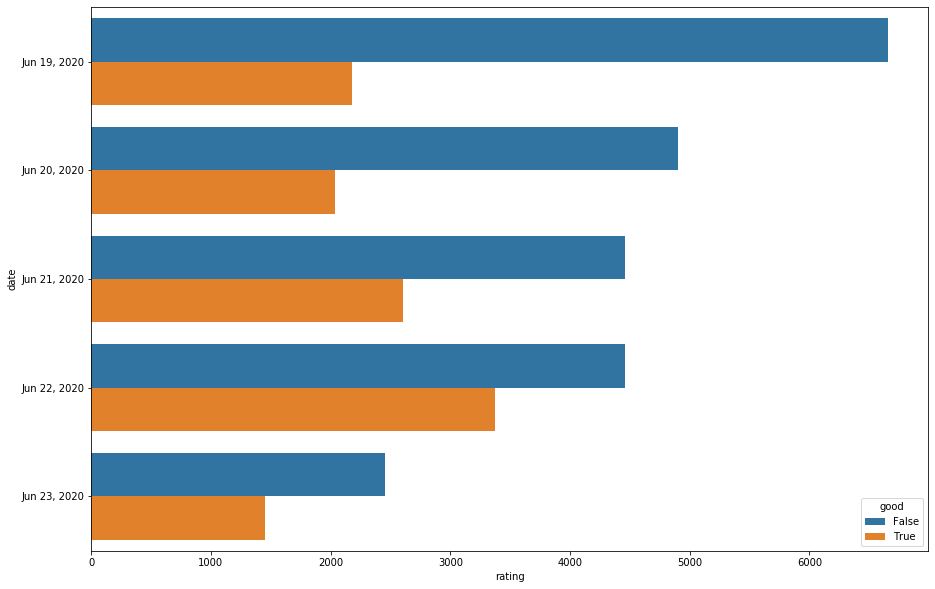

In [262]:
fig, ax = plt.subplots(figsize = (15,10))

sns.barplot(y = 'date',
            x = 'rating', 
            hue = 'good',
            data = reviews.groupby(['date','good'])['rating'].count().reset_index());

As we can see, good reviews only reached a peak days after the release of the game, which may suggest that people actually played the whole game before reviewing.

Now, let's take a look at the rating behaviour.

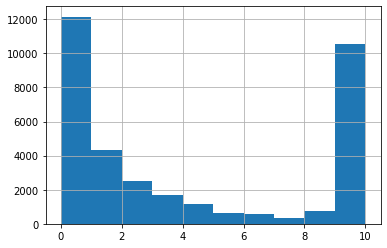

In [264]:
reviews['rating'].hist();

We can see that there is a huge polarization between 0's and 10's.

### 3.2 Text Pre-Processing

Here we will treat the text to make it easier to analyze.

First of all, let's convert all text to lower caps:

In [195]:
reviews['review'] = reviews['review'].apply(lambda x: x.lower())

Now, let's get rid of special characters:

In [196]:
review_backup = reviews['review'].copy()
reviews.review = reviews['review'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

Now, we will create a function that takes a column with the reviews and converts it to word tokens, so we can better analyze the reviews. 

Also, it will remove english stopwords, so it doesn't pollute our analysis.

In [270]:
def get_word_tokens(series):
    '''
    This function gets all the text from one column and converts it to word tokens.
    
    Parameters:
    series: Column to be broken down into word tokens
    
    Returns: Word tokens
    
    '''
    eng_stopwords = stopwords.words('english')
    ### Getting a single string
    text = ' '.join(series)
    ## Splitting them into tokens
    word_tokens = nltk.word_tokenize(text)
    ## Removing the stopwords
    word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
    return word_tokens_clean

Now, we create a function that uses the function above to get the word tokens and get the top k n-grams from any text column. That is, it presents us the most common combination of any number of words in our reviews.

The image below gives a better view of ngrams:

<img src="images/ngrams.PNG" alt="ngrams" width="400"/>

One very good use of this feature is to understand the differences between positive and negative reviews' n-grams.

In [287]:
def top_k_ngrams(series,n,k):
    '''
    This function gets the top k n-grams from a column.
    
    Parameters:
    series: column to be analyzed
    n: integer that represent the number of words to connect
    k: integer with that limits the ranking
    
    Returns: text with top k n-grams
    '''
    ## Getting them as n-grams
    word_tokens = get_word_tokens(series)
    n_gram_list = list(ngrams(word_tokens, n))
    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(list(most_common_k))

Now, we break our datasets into bad and good reviews, so we can analyze them apart.

In [283]:
reviews_good = reviews[reviews['rating'] > 6]
reviews_bad = reviews[reviews['rating'] < 5]

### 3.3 n-Grams Analysis

Alright! Now let's see the top 15 n-grams for both good and bad reviews.

**Bad Reviews** first:

In [288]:
top_k_ngrams(reviews_bad['review'],1,15)

[('game', 36690), ('story', 15583), ('first', 7841), ('joel', 7664), ('like', 7096), ('characters', 6248), ('ellie', 5891), ('gameplay', 5539), ('bad', 5308), ('good', 5266), ('one', 5145), ('play', 5097), ('character', 4835), ('abby', 4717), ('last', 4504)]


Well, obviously we have some pretty expected words, such as `game`, `bad`, `play`, `good`. We could have solved that problem by trimming away the 5th percentile of most common words. But in this case, I believe that analyzing them could give us good insight. 

As we can see, `story` is the second most common word, that may lead to something, most of all because it is followed by `Joel`, `Ellie`, `character` and `Abby`. That is, most of the common words are related to the gameplot.

Now, let's see if the bigrams gives us more insight:

In [289]:
top_k_ngrams(reviews_bad['review'],2,15)

[('first game', 4139), ('naughty dog', 3257), ('joel ellie', 916), ('game play', 899), ('game story', 879), ('first one', 819), ('last part', 720), ('nesnasim gaye', 706), ('gaye nesnasim', 706), ('buy game', 624), ('game game', 594), ('neil druckmann', 574), ('bad story', 565), ('first part', 563), ('play game', 558)]


Well, it's really close to the first, lots of references to the first game, lots of reference to the story and the writer. My guess is that most of the complaints are related to the story. We will be able to see that further on.

Now onwards to the **good reviews**:

In [290]:
top_k_ngrams(reviews_good['review'],1,15)

[('game', 19692), ('story', 6777), ('que', 4678), ('people', 3432), ('like', 3218), ('ellie', 3207), ('first', 3201), ('gameplay', 3107), ('joel', 2911), ('one', 2910), ('play', 2649), ('good', 2390), ('abby', 2372), ('great', 2155), ('best', 2150)]


Also lots of things related to the story and its characters. Let's see the bigrams:

In [291]:
top_k_ngrams(reviews_good['review'],2,15)

[('naughty dog', 1757), ('first game', 1334), ('best game', 766), ('last part', 629), ('one best', 535), ('play game', 529), ('great game', 517), ('first one', 486), ('hist ria', 486), ('game ever', 461), ('game play', 419), ('good game', 386), ('played game', 380), ('ever played', 353), ('game great', 338)]


It has less terms related to the story, it is mostly terms related to how good the game is. Also, we can see that is less concentrated than the bad reviews.

### 3.4 Story Analysis WIP

Now that we saw that most of the complaints are related to the story, one thing that we can do is to look for words connected to the word `story`, both on the bad reviews and on the good reviews. 

We will make this analysis using NLTK POS TAGGING. It will help us a lot to understand the data, because we will be able to look for the closest adjective, or noun, or any other important class of word.

First, let's create a function that does that for us.

In [320]:
classes = [ 'JJ']

def ExtractInteresting(sentence, classes):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in classes]
    return(interesting)

In [327]:
def next_word(sentence,word):
    post = re.findall(r''+word+'.*', sentence)
    if (len(post) > 0):
        temp = ExtractInteresting(post[0],classes)
        if (len(temp) > 0):
            return(temp[0])
        else:
            return('')
    else:
        return('')


In [332]:
post_good = []
ind = 0
for sentence in reviews_bad['review'].values:
    temp = next_word(sentence,'gameplay')
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
print(top_k_ngrams(nonempty,1,15))

[('good', 347), ('first', 236), ('bad', 143), ('great', 123), ('last', 90), ('much', 79), ('boring', 79), ('new', 63), ('repetitive', 57), ('fine', 53), ('similar', 49), ('terrible', 47), ('original', 45), ('horrible', 40), ('little', 35)]
None


In [331]:
for sentence in reviews_bad['review'].values:
    print(sentence)
    print('-----------')
    print('             ')

beautiful but bleak an some really questionable actions and scenes for amount of gameplay  price is iffy takes what they built in the first game an wipes the board clean 
-----------
             
i m not going to say anything different from the other users  amazing technical details  good gameplay  but the story is so bad  awful  destroys everything you love about the first game 
-----------
             
the game is visually stunning all around  and the story is not as a huge mess as many would expect but in the latter half of the game things just get awfull and just plain underwelming and confusing the ending scene where abby is just left to live is a huge hit  and some decisions elly makes  leaving her family  are not like her and take away from the original story 
-----------
             
the graphic  gameplay and atmosphere is great  but everything is destroyed by the story  which doesn t make any sense and destroys the whole experience 
-----------
             
what a letdown 

-----------
             
first things first  i m a huge naughtydog fan so don t get me wrong  naughtydog has been an amazing game company for more than a decade but let s cut to the chase  tlous2 is not good  at least in a matter of storytelling  how come  pretend naughtydog gonna announce uncharted 5 in the next e3 and you just gonna get hyped for playing it and afterward  after playing it for 2 hours  nathan drake is gonna get killed  hurts  it really does because he was the main reason you have probably bought the game in the first place  there s a similar scenario for tlous2  you have bought the game not just for great graphics and gameplay but for the masterpiece storytelling you experienced in the first game  you bought the game for the strong emotional connection between joel and ellie  why would the writer gotta kill off the character that made you in love with the game in the first place  it makes no sense  that s why people are mad  ofc they love the gameplay  graphics but w

overall  the graphic and game control is excellent but a horrible setting on the story and character  you could have achieve the same effect by crippling joel or just make him severely injured and went into coma a bad reason to start up a merciless revenge  i mean  did joel torture  his victim before killing them  no he gave them a swift and quick death  you tried to make abby looks innocent by having a reason to kill joel  yes you had a strong and valid reason  but your reason doesn t make any sense to give her any reason to torture somebody to death i felt deeply offended on the discrimination part against jesse  what kind of double standard do you guys have to make such a bad joke
-----------
             
this game is by no means as bad as some people make it out to be  but neither is it a masterpiece  the mechanics are ripped out of the new tomb raider games with stealth  crafting  melee and gunplay  though there is a slight addition of watching your trail with dogs that can sniff

             
boring storyline  no freedom whatsoever  more boring than episode 1  wont recommend
-----------
             
u killed joel for no reason and finally what a revenge from ellie  go away lol abby took her father revenge and ellie what she did  she just ket abby go
-----------
             
this is an insult to the gaming community from a developer that did so well with the last of us 1 with it s storytelling and gameplay  to follow such an incredible game with this is horrific to say the least the gameplay is clunky and has seen no real improvements since the first game which is surprising considering how much time they had to create it the visuals are really no better in comparison to the first but has opted for a darker and woefully dull colour scheme lastly the main glaring issue with this game  the storyline  in some woke new age where naughty dog s main man neil druckmann has decided to remove the fun from his game to portrait a forward thinking agenda  he has complete

-----------
             
if you re expecting a game similar to the first one  this is half it  the scenery  astonishing  the voice acting  really good  but then we start going downhill from there  the gameplay or what little there is of it lol  some say its gisnt  personally i didnt like it  but the worse of it  the plot  they manage to turn a masterpiece and possible best game of last decade into nothing  it is indeed addictive because you re constantly trying to get revenge  but for nothing  its all in vain  it doesnt give you any sense of accomplishment whatsoever  i think the last of us part 2 would be better suited as a netflix series rather than a video game  poor choices made by neil 
-----------
             
i m going to get the incredible characteristics of this game out of the way there is no doubt in my mind that this may be the most stunning video game i have ever played    the graphics are out of this world  the audio design is complex and atmospheric  the voice acting w

-----------
             
what a mess this game is story wise  it s as if it written by a 13 year old edge lord  for a fan fiction site  seriously this game just spits on the fans of the first game  and laughs while doing it   if you have to play this game just rent it  or wait a while for it to go on sale  don t pay full price for this dumpster fire 
-----------
             
puntos negativos no recomiendo a nadie gastarse 60  en un juego que pr cticamente se juega solo  y que a pesar de ser pr cticamente una pel cula interactiva  se esfuerza en cargarse en la historia una y otra vez la parte del juego en la que tienes que usar a abby es insufrible  estas deseando matarla  te interesa una mierda su vida y a n as  te obligan a tener que jugar con ella  en un barato intento de hacerte empatizar con el semihumano que acaba de matar al mejor personaje de la franquicia tienen a dos lesbianas todo el dia magreandose y no ense an nada de tijeritas  y luego a la orcotroll  de abby  que es mas

             
production  game design  voice acting  etc  10 10  character arc  plot 0 10  the first half of the game felt completely different from the second half  when i got back to the first part i didn t know what was going on tbh  to end the game on a  yep  isn t it when the game got first announced the hype was insane that this was kind of a let down sadly  but it isn t a bad game because of the gameplay alone  i give it a 3 10
-----------
             
with the last of us ii they went for something different from the first game  you don t get two characters solving problems and slowly growing together throughout the game  what they did is interesting in concept and could have been great had they pulled it off  they tried to tell both sides of a story where no one is in the right  while at the same time making it subversive and obsessively mirroring events  some of it works  they created a masculine women that maintains the same male love interest the entire game that the intern

great looking game  8 10  average game play  5 10  horrible story  0 10  horrible sequel  0 10 2 5 10 rounding down to 2 for deceptive advertising  if you loved tlou  avoid tlou2 at all cost 
-----------
             
5 hours in and i had to call it  the gameplay is fine  and the graphics are amazing  but the story and characters are just slogs  none of them are relatable or easy to care about  even ellie and joel are so detached from what they were i grew to hate them  even tho with joel i barely got any time with him before plot brain kicked in and got him killed  this story is a spit on the legacy of the first  i remember getting the first one in 2013 and staying up to late to go to work the next day and instead of sleeping i kept playing and beat the game in 1 sitting  with part 2 i took multiple breaks after rolling my eyes to many early story points and when they made me take over the awful character that killed a good character i lost all interest in pushing to the end  i will n

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




while the gameplay and set pieces are great  the story really takes a downhill nosedive with unlikable characters  unquestionable plot choices and plot holes  a revenge plot that is so shallow  other games have done better  and the send off is not worth the 40  hour gameplay overall 
-----------
             
it was quite disappointing that you destroy a masterpiece  now that s some talent   from the last of us 1  people are immerse by the  story  here you keep destroying users what they love  playing god because you want to   its just sad to see another game destroyed by some political agendas  it will be difficult for you to make another sequel to it  people will not buy it  you already put the last nail in the coffin  2013 tlou was great game of the year definitely  2020 tlou2 was just a complete garbage  it will not be remembered after few weeks 
-----------
             
most of the negative reviews pretty much sums up why it s bad well  it s true 
-----------
             
the g

-----------
             
what a ridiculous storyline this game is  it is ironic that all the scores 
-----------
             
if you want all that revenge and being gay   just go and make a new game  what happened in the dlc was a mistake you should ve jumped  don t ruin the game just because you are a simp for a feminist 
-----------
             
so this is where we are in video games  gratuitous sex scenes for no literal reason  this game has a flat story with no worth while characters or character development for that matter  this game just takes a steaming dump on the first games story and world building  anyone who rates this torture porn garbage a 10 is sick in thr head
-----------
             
      2                                      1                       
-----------
             
disgusting attitude towards the fans of the previous game naughty dog  wasted the best chance to continue the tlou ip 
-----------
             
  nd double meaning i ve been searching for w

             
it s bad  very very bad and this is bad yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy
-----------
             
remember your feelings about got s8 ending awful writing  everyone from nd old good games are gone  this guy cant create or even make good use on something already done 
-----------
             
good graphics  awful story they spit in the face of fans with this waited 7 years for this effort is an absolute disgrace 
-----------
             
okay game mechanics if you played the first game you ll feel no noticeable changes  also the story is hit or miss personal i did not find it entertaining or intriguing 
-----------
             
such as   don t play it  i really regret  waste my money  don t trust officials and other utuber
-----------
             
disappointment on weak story writing skill and   up marketing 1 is for the graphic 
-----------
             
this game is trash  story is trash eavry thing is trash  good thing there s offer up to at least get half of my

-----------
             
there s no place for pol1tics in games  i m truly dishearthened by the turn my favourite game series has made 
-----------
             
i dont mind ellie being gay or someting  really  but they destroyed the whole story for nothing  the whole story is a trainwreck  see skillups review on youtube 
-----------
             
 fireneildruckmann  the leaks are true  but the game is even worse than i expected  paid reviews and false advertising  things you loved about the first one is gone and replaced with questionable motives and actions  buy this game at your own risk  you have been warned 
-----------
             
bad writing  bad story  bad lgbt  bad game  bad 60 dollars  bad endingjust freaking buy ff7  p5r  ghost of tsunima or doom eternal  worth of 60 dollar rather this pointless sequel 
-----------
             
the immersive writing and discussion of moral decisions made in the first game really set the bar for high expectations for the sequel  after a 7

when did killing pregnant women become ok in entertainment i would urge parents not to let their kids anywhere near this horrific filth of a game yuck 
-----------
             
a great first game people loved to death  we wait so long  and we receive this crap  from buying console only to play the last of us   to   not even wanthing to play anymore  because this game had so many political adgendas pushed the plot had more holes than an ant nest 
-----------
             
i have not finished it yet but i am not really enjoying the story anymore as it is simply too far away from my personal reality which means  i simply can t relate and don t even want to  providing a basis for a very questionable woke ideology seems more important than good story telling  so  was it really necessary  holy     thank you naughtydog for this piece of garbage 
-----------
             
it is absolute utter trash compared to the first game in terms of the story  the visual are probably the best i ve seen on

-----------
             
angry feminist wisperd in nail suckmanns ear to kill of joel because he stands for the manly man  nail suckmann is a simp and messed one of the best games  last of us 1  and characters  joel  that is ever made 
-----------
             
bad story  sjw propaganda  seeing who is behind this game there is no way to give anything but 0 
-----------
             
neil druckmann completely ruined this series  should ve kept the original writers instead of firing 75  of the studio after the story was almost completely finished and replacing it with his own 
-----------
             
save some money  let developers see the point  and leave this trash out  is cd project  from software  santa monica and a pile of good ass indies all we have left 
-----------
             
the story sucks so much  killing off one of the best characters in gaming history is a bad idea
-----------
             
naughty dog took  a great game with a great story and characters and made   thi

-----------
             
if you like got season 8 and last jedi you will problably like this thing but if you do not then better to stay away killing and changing well like characters for the sake of shock value idiotic sex scene with neil     a she man and a revenge arc with no revenge at the end is like if john wick went after the guy thatt kill his dog kill thousands of henchman and at the end decides not to kill the guy because revenge won t bring him happiness wtf f  this game
-----------
             
igra govno ebanoe idite nahui so svoei propagandoi ahhaahahahahahahah xyesosi razrabotchiki
-----------
             
trash   trash   trash  trash   trash   trash   trash  trash   trash   trash
-----------
             
game full of bugs  story sucks  definitely not what i was waiting for  the point is the time that we waited to play this 
-----------
             
wtf was that  the main complaint is the plot component and the sjw agenda  it is also worth noting the outdated gamepl

-----------
             
the final word of the script is literally yep yep cock  horrible story  horrible characters  gameplay is good but after 20 hours you get bored of doing the same things over and over
-----------
             
dont believe the critics or should i say paid shills  no way this is 95  rated game 
-----------
             
ruined a  hmm  a fair not so great game  bending the knee to the clownworld  the minority is the majority etc  extremist left wing agenda  i want my money back 
-----------
             
ruined a  hmm  a fair not so great game  bending the knee to the clownworld  the minority is the majority etc  extremist left wing agenda  i want my money back 
-----------
             
             
-----------
             
i hate this game  i hate naughty dog  this monster abby kills joel and we have to play with this monster  the ending ist sh t   ellie left her family  loses 2 fingers because of thi monster abby and she let her go  i hate you neil f ckman  g

-----------
             
i played the game expecting something dark but not like this  the last of u part 2 is excessively bleak and depressing and lacking in what made the first game great
-----------
             
the version of game of thrones season 8 in a videogame  what the actual   were you thinking  such disrespect towards fans  literally disgraceful 
-----------
             
just what i needed  transgender buttsecks in high resolution  pacing   shallow   unbelievable characters  mixed with grotesquely inept writing  also the gigantic ego of druckman putting himself in the game as maxed intelligence card  just wow  i will never buy anything from this studio ever again unless the studio is completely rebuilt with new leadership  not to mention the flagrant illegality  of abusing the dmca copyright system 
-----------
             
  game thx xqc for savin me money love u xqcheard iko0sdfgikodfmgsi sodfjfjgn0dosjgnasdiu9r9gjnfasdr89iugjnadsr9iunge9dru8ngeru89ngr89dungrdu89ngrd8

             
first and foremost   this game is not the continuation of last of us story  this is nothing but a fan fiction  amateurish  vain  talentless  perverted  it is as bad  as latest terminator movie  the story is based only on a revenge  there is no character development  no emotional connection  remember how long it took ellie to build a relationship with joel in first game  how long it took joel to overcome the loss of his daughter  and to adopt ellie  well screw you  now there is girl  you kissed the day before the game starts  the next day you re making out and all in love  also  authors use this logic for the whole game   here we take something away from  and you should be angry  this is a stupid 80s action movie  but not fun at all  gameplay is literally the same as original last of us  no new mechanics  no unique encounters  you either slowly walk and loot  or run and shoot  looting is boring   you can only interact with 1 or 2 objects on scene  shooting has no feedback 

-----------
             
best game evar 10 10  i like cheese and sometimes i eat meat  btw how are you 
-----------
             
the gameplay is boring and monotonous  the plot is terrible and uninteresting the ai sucks and most enemies are reused often  with a plethora of bugs  the only redeeming quality about this game is the character models and voice acting 
-----------
             
worst story  gameplay looks amazing but the story is trash  fire neil druckman  0 10
-----------
             
  the graphics ppl dont buy tlou games for  in  graphics they  in  buy it for the damn story but congrats naughty dog on  ing up the masterpiece which is tlou with a   good for nothing sequel definitely don t buy it ain t worth even a damn penny
-----------
             
this is not the way to carry on a story  if nd is interested in narrative experimentation in playing as a character s killer  then i think a new ip would have been the place to do it  don t spit in the face of the fans  i lo

             
my disappointment is immeasurable  and my day is ruined i waited 5 years to play this and they gave me a horrible intro and   ending i just want to forget about this game 
-----------
             
worst homophobic game  story is so bad i went to gamestop ane refund it within day 2
-----------
             
this is reaction to positive rating bombing  the professional reviewers are obviously lying to us  10 out of 10 is a lie  they are motivated to make positive hype  the story is bad as well as ending  i will never ever trust again paid reviewers 
-----------
             
this is wrong i v waited for long 7 years for what   to kill the main characters just like that  
-----------
             
f por la compa ia amigo  se fue al ca o la historia por una guionista feminista 
-----------
             
                          1                    
-----------
             
mediocre game play  okay graphics  the story is so bad  cringe  and disturbing 
-----------
        

it s a walking simulator  at least  death stranding is more fun  be it for the gameplay and the storyline  it is perfect and meaningful  the last of us 2 is a garbage piece of   the whole journey thing with ellie  yeah thats the walking simulator 
-----------
             
porcoddi0 sono appena tornato dall ospedale e indovinate un po  mi hanno diagnosticato la sifilide io sono gi  immunodepresso dato che ho contratto l hiv dopo aver giocato a destiny 2 e per sbaglio ho commesso lo stesso errore della prima volta  ovvero ho apeto il gioco senza aver indossato il preservativo mi raccomando ragazzi state attenti a questi giochi pericolosi 
-----------
             
very disappointing game  full of endless violence without any reason  the story is very weak with unidimensional characters  it s a shame sony paid reviewers to give a good note for this crap 
-----------
             
why one of the most fantastic games has to be ruined  this is unfair  aysusuyajautiurriasri
-----------
     

             
imagine loving someone like a father for 7 years  just to   on him to his death 
-----------
             
been a naughty dog fan boy since day one  crash was the most played game of my childhood and the uncharted series my favorite of all time  lou part 1 was probably the greatest story telling game that most of us had ever played with incredible emotional connections to the characters  all that said  i m extremely disappointed with part 2  do not buy this trash  killing off joel to destroy the patriarchal protagonist that we all loved with this new age juiced up golf pro with a grudge was more than a slap in the face for those of us who truly had strong feelings for his character from the first game  i hope that the negative honest reviews continued to pour in  if the writers of lou 2 continue to create content for naughty dog then my days of loving and enjoying this company are done  video games are supposed to be a grand escape from the sjw bs that is constantly and f

             
you need to control the beach who kill joel are you kidding me  naughty dog
-----------
             
i hope the game devs go home and budd dwyer themselves over this failure of a game and political nonsense 
-----------
             
cons  story and characters   a large portion of the game is just you roaming empty places and picking up stuff   boring flashbacks   enemy ai   world level design   pros  decent gameplay  graphics  soundtrack
-----------
             
                         
-----------
             
terrible game  shouldn t even be considered a game  it was a dirty trap to people who fell for this bein a game and instead are forced to eat up lgbtxyz bs  to me the last of us 2 ain t canon 
-----------
             
this is game is so fcking   bad   hole or no   hole is better than this game lol  
-----------
             
the 2nd worst game of all time  this   drivel is the most disappointing thing since mass erect 3  basically this game is like if the med

             
um lixo apenas  gameplay incr vel  hist ria horrenda  estraga a experi ncia 
-----------
             
after this game  i will migrate to the xbox  i don t care about sony exclusive games anymore 
-----------
             
what a joke  2020 couldn t get any worse  this site does not even allow me to post my reviews
-----------
             
insane   i dont know people why likes this game its horrible the only good thing in the game is the gameplay but only that dont go expecting a great story like the original tlou
-----------
             
i expected more  the game slid into the abyss   the story is complete  
-----------
             
the game si a real     how can they   such a good game  spend my money for a disappointing story 
-----------
             
well  pure   no coments about this trash game  how destroy a mitic franchise
-----------
             
marvelous graphics just as it was expected unlike the story  i was astonished when joel died but i accept it ellie

worst story ever  naughty dog should be ashamed of themselves the last of us 1 was a masterpiece part 2 pure trash
-----------
             
very tedious and repetitive and the ending was very unsatisfying after all that hard work i do not recommend for anyone who wants to have a fun experiance 
-----------
             
i felt that what was advertised was different from what i bought   the graphic do look nice though 
-----------
             
don t bother with this one  this is not the sequel people wanted  this is some pitiful revenge story injected with sjw agenda full of gay and trans bs  pros  graphics and game play are good but story is so progressive bs that it ruined the franchise and is an insult to the first game   very sad about it  hopefully cyberpunk 2077 will be what people expect 
-----------
             
the game is one of the worst  the gameplay was boring like the same thing over and over again  the story was awful the characters were ruined  whole game is just abou

-----------
             
this is not a hit at all   hard pass   why would they bother   who appproved this abysmal poc
-----------
             
aburrido   sin buena historia   tendencioso a m s no poder   no se puede ser m s aburrido de verdad
-----------
             
si bal gae jot byong sin game neil druckmann jon na kill ha go sip nae  fdzz
-----------
             
imagine a mario game where bowser tries to kidnap the princess  fails  escapes  and then mario spends the whole game chasing bowser just so he can teach him a lesson   the last of us 2 has pretty much the same feel   what an annoying story  just pretty ridiculous   feels more like a really violent soap opera than just good vs evil     like other reviewers have said  it really is mostly about revenge   call me old fashioned  but i ve always been more a fan of games with an existential threat as the focal point 
-----------
             
you can ruin this way anyway  joel and ellie are the main characters  revenge  hatr

             
what a disappointment  and an absolute waste  i ve been looking forward to this game for a long time  and now i won t even get to enjoy iy 
-----------
             
total failure  total disappointment  naughty dog just insulted predecessor by themselves 
-----------
             
after the first game this is so disappointing the story is horrible  annoying false advertisement  character you are avenging for is so predictable they have to lie to you   play half of the game for the character you want to kill  move does not work at all waste of time and money 
-----------
             
huge let down  preposterous story  overlong and padded  enough reviews have come in now for the truth about this to be outed about this bizarre catastrophe  avoid  avoid  avoid 
-----------
             
this is a terrible and low level game  this game deceived users  this game is made to not recommend to anyone 
-----------
             
10 10 for stupidly developed characters  thank god i d

-----------
             
el juego es una total perdida de tiempo  asesinan al personaje principal de una forma tan in til  y al final la protagonista es feliz al abandonar su hogar por segunda vez y luchar contra una fam lica enemiga que le arranca dos dedos jajaja en que estaban pensando
-----------
             
stop the trash and ruining the story and stop putting inappropriate things to a game we liked once before  it s a shame to one of the biggest studios to do that 
-----------
             
this game takes everything you love from the original and craps all over it  predictably scores are being deleted because people have no sense of honor or spine anymore  this isn t about a political message  this is about bad storytelling  the story is so awful  with the same bland gameplay of the original  let s not pretend tlou 1 had great gameplay  it had an amazing story though and that s what carried it  tlou2 makes that story retroactively worse by giving it one of the worst conclusio

gameplay is boring and monotonous  the plot is bad and uninteresting  only the graphics is good  do not waste your money 
-----------
             
joguinho de lacra o achei a hist ria bem merda que era o  nica coisa que diferenciava esse jogo dos demais tudo que foi constru do no primeiro game foi jogada no lixo  e apenas um game para agradar os esquerdista da lacra o
-----------
             
discasting discasting discasting discasting discasting discasting discasting
-----------
             
this game was a failure to its predecessor and ruins the legacy of the first game 
-----------
             
if you are letting abby kill joel  you should make abby a hot woman  because abby is ugly as  stupid game braindead game  ellie goes for kill abby  she kills all abby s friend but unbind abby  braindead
-----------
             
7 largos a os para que nos den esta porqueria de juego  y no  el juego no es bueno  es increible que exista gente que defienda lo indefendible  la historia escup

             
good the picture of the game  beautiful scenery   and nice ui   but the worst story ever 
-----------
             
are you serious   i waited how many years  part 2 is a middle finger to devoted tlou fans and is borderline unplayable unless you enjoy spending 30 dark hours caring about no one or nothing in it   it is contrived  soulless  shock value garbage compared to the rich character development of the first  this is a fact that has nothing to do with lgbt themes   incredible disappointment   has anyone else noticed that the majority of 10 10 reviews include bouquet throwing to nd   riiiight   they have bad writers everywhere it seems 
-----------
             
this is message for the company if you need money  make an another saga or another game  don t wrecks this game  for a player if you want play it but it s a real  
-----------
             
imposible que maten a joel y tambien a tommy  el gameplay es bueno pero la historia carece de sentido
-----------
       

-----------
             
bad story  bad ending  i really liked the first one  found this storyline very disappointing 
-----------
             
simple  storywise the worst sequel i ve ever played  don t spend your money on this one 
-----------
             
i work at gamestop and we gave this game away for free because we over ordered but alot of our customer will not take it even thought its free  now we have to recoup our lost by increasing the price of our other items  i hope the boss wont repeat the same mistake when ps5 come out 
-----------
             
que triste que sigan arruinado la historia de este juego al meter ese tipo de temas de hoy en la actualidad  esperamos muchos a os y el juego est  renovado se ve fabuloso pero al jugarlo es como comer algo a la fuerza que triste a d nde van a parar los videojuegos por temas politicos
-----------
             
                                                                                                                       

                            
-----------
             
thanks go out to anita sarkeesian for making it a political agenda and not a good story story is the worst i ve ever played 
-----------
             
8 hours into the game and it is amazing  great story and characters in combination with good gameplay  i would definitely recommend this as one of the top 10 games for ps4  looking forward to last of us iii on ps5 
-----------
             
its just a bad fanfic from neil druckman dont even bother or support the game this is the reason why 70  of naughty dog quit their jobs or were fired after uncharted 4
-----------
             
the story is awful  joel butchered like a dog by a character noone cares for  outrageous  you are forced to play this behemoth of a woman and attack ellie who is a protagonist  very disappointing storytelling  graphic and gameplay are nice 
-----------
             
i m sick   tired of all this racism  sexism   bigotry against straight white men  this is a 

from the moment i finished part 1  5 years ago  i waited for this title  now i wish that there was no 2nd part of this  for a game that is heavily story based  this game falls flat  graphics and action is something that you ll find in every other title that releases nowadays  the gameplay is repetitive and not at all as fun as it was in part 1  if the makers were going for a tragedy title  this isn t actually a tragedy  there is some kind of fun in tragedy  i did not enjoy this game at all 
-----------
             
god awful now just increasing the character limit  jsjsjkskswoaoqoq99qq9sisiseiiwiwosos9e9wowososoe9ewowowowowosososiso8sis8s8s8a8
-----------
             
i m not crying for a game long time ago  this game made it  cause the horrible  disgusting story  good job neil  u just made it 
-----------
             
puro j0to le gusta este juegomucha publicidad inclusiva insertada forzosamente como parte del juego
-----------
             
honestly  bad scripts bad story nice gam

-----------
             
this is a good example of how you ruin a good franchise   most of the buildings are boarded up and it pushes you down a very set path   the story is horrible and full of virtue signaling nonsense 
-----------
             
the writing makes the characters incredibly stupid to push the terrible plot  bad game  bad writing  pretty though 
-----------
             
  agenda pushing narrative with a crappy overall story  pure garbage 
-----------
             
joel vie uccis da un tranz che non ce ne fotte a nessuno basta co ste cose dei froci porccoddio
-----------
             
poor storytelling  nice animations  but storyline trying to fit current agenda  sorry  no 
-----------
             
i am really disappointed  the games goes nowhere and wasted so many opportunities  killing the main character like this was such a waste  it could have been so good  keeping the same story but the way it was done is such a disappointment  i must say that the level design is

disgusting  never have i been more disappointed in a game  horrible writing  zero character development  forced and undeserved emotion  way to desecrate amazing characters  and an amazing world  i was going to go easy on it because there are some flashbacks that are genuinely very good  but the rest just sours everything too much and what a terrible reveal and reason for joels end  predictable  boring  bland  and all to serve  developing  druckmanns garbage fanfiction character  what little is there is too little too late  i would rather have burned myself with a fire made of 60 dollars than have bought this game  this game deserves and has earned every bit of hate and every bad review  people call it review bombing because they desperately need to have a  progressive  game to look at and feel represented by  make something good and if it happens to have gay characters and such then great  you know like the first game  just another case of politics and thirst for lib clout ruining some

In [316]:
def loc_word(serie,word):
    '''
    This function seeks and plots all the reviews containing a specific word and the 20 characters before and after it.
    
    Parameters:
    serie: The columns we will look into 
    word: The word it will seek, must be a string
    
    Return:
    String with all the sentences it was found.
    '''
    
    reviews_containing_word = [each for each in serie if word in each]
    for review in reviews_containing_word:
        word_index = review.find(word)
        print(review[word_index-40:word_index+40].replace("\n", ""))

In [281]:
loc_word(reviews_good['review'],'story')

lie to go mad and her quest for revenge story is a brutalistic masterpiece  do i

al game in nearly all aspects including story telling  gameplay and graphics
most beautiful worlds ever created  the story is shocking and real 
makes it even more fun to play  and the story is bleak  violent and moving  just
nd very quickly in the game  but joel s story is told  every story is told at so

s and it is a gem i love it so much the story is incredible

le  i loved it  but i can t believe the story   it is very bad and it doesn t co
 players would concentrate on the whole story  without specifying certain moment
e satisfying and work together with the story to build this vibrant world the ga
e first in class graphics  gameplay and story  but also play it because the tear

s don t ruin the game or don t make the story bad yes joel dying near the beginn
is is the game of the generation  great story  best animation of any game from a

ing  i dont need to talk much about the story  what i liked t


imation was a little less taken care of story mode and plot  9 5 10 the story mo
ay i was not upset at certain things or story arcs however that by no means lowe

imation was a little less taken care of story mode and plot  9 5 10 the story mo
rs  and it s as good as i expected  the story line connects very good with the f
bby s atonement  if not for lev  abby s story would be much different  lev is he
 shine when compared with  the rest  2  story is actually terrible and the chara
 t understand why people don t like the story i found it really immersive and in
 die gewalt und das angeblich schlechte storytelling und die story selbst  zu pu



hnical marvel and achievement  yes  the story isn t that engaging as the first o
s amazing tech  graphics   gameplay and story  so tired of cancel culture see so

what makes it brilliant  apart from the story  i can t believe how real this gam

e will not always be happy endings  the story is crude but i would say that it i
sten to them  wonderf


oose  as someone whose favorite form of storytelling is a tragedy  and whose fav
hort compared to the first game  is its story and characters   spoiler alert  th
merican commedy  not a horror survival  story is trash  characters are bad  i m 
irst game was about love and i love the story between joel and ellie  but this g
he game is very good  unfortunately the story in the final part has been very lo
c political beliefs  on a technical and story telling level  this is a great gam
y  but this game is focus only on the history  not that great as it was said
el uncomfortable with the direction the story took in relation to the characters
he characters all look pretty good 7 10 story   the story takes a turn for the w
lutely love this game  i agree that the story can get the slightest bit dry at t
ice  loot box filled  games with bad no story  naughty dog and sie  don t worry 
 though it did start a little slow  the story is fine and the graphics are great

nd trustworthy reviews  jk  ev